#### Analyzing Neural Time Series Data
Python code for Chapter 34 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal, stats
from scipy.fftpack import fft, ifft
from scipy.stats import norm, t, rankdata
from scipy.signal import hilbert
from scipy.ndimage import label
import os

In [2]:
# Load sample data
data = loadmat('../data/sampleEEGdata.mat')
EEG = data['EEG'][0, 0]

# Definitions, selections...
chan2use = 'FCz'

min_freq = 3
max_freq = 30
num_frex = 20

# Define wavelet parameters
srate = EEG['srate'][0, 0]
time = np.arange(-1, 1 + 1/srate, 1/srate)
frex = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
s = np.logspace(np.log10(3), np.log10(10), num_frex) / (2 * np.pi * frex)

# Define convolution parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0] * EEG['trials'][0, 0]
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = int(2 ** np.ceil(np.log2(n_convolution)))
half_of_wavelet_size = (n_wavelet - 1) // 2

# Note that you don't need the wavelet itself, you need the FFT of the wavelet
wavelets = np.zeros((num_frex, n_conv_pow2), dtype=complex)
for fi in range(num_frex):
    wavelets[fi, :] = fft((1 / (s[fi] * np.sqrt(np.pi))) * np.exp(2 * 1j * np.pi * frex[fi] * time) * np.exp(-time ** 2 / (2 * (s[fi] ** 2))), n_conv_pow2)

# Get FFT of data
chan_idx = EEG['chanlocs'][0]['labels']==chan2use
eeg_data = np.reshape(EEG['data'][chan_idx, :, :], (1, n_data), 'F')
eegfft = fft(eeg_data, n_conv_pow2)

# Initialize
eegpower = np.zeros((num_frex, EEG['pnts'][0, 0], EEG['trials'][0, 0]))  # frequencies X time X trials
eegphase = np.zeros((num_frex, EEG['pnts'][0, 0], EEG['trials'][0, 0]), dtype=complex)  # frequencies X time X trials

# Loop through frequencies and compute synchronization
for fi in range(num_frex):
    # Convolution
    eegconv = ifft(wavelets[fi, :] * eegfft)
    eegconv = eegconv[0, :n_convolution]
    eegconv = eegconv[half_of_wavelet_size: -half_of_wavelet_size]
    
    # Reshape to time X trials
    eegpower[fi, :, :] = np.abs(np.reshape(eegconv, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    eegphase[fi, :, :] = np.exp(1j * np.angle(np.reshape(eegconv, (EEG['pnts'][0, 0], EEG['trials'][0, 0]))))

# Remove edge artifacts
time_s = np.argmin(np.abs(EEG['times'][0] - (-500)))
time_e = np.argmin(np.abs(EEG['times'][0] - 1200))

eegpower = eegpower[:, time_s:time_e, :]
tftimes = EEG['times'][0][time_s:time_e]
nTimepoints = len(tftimes)

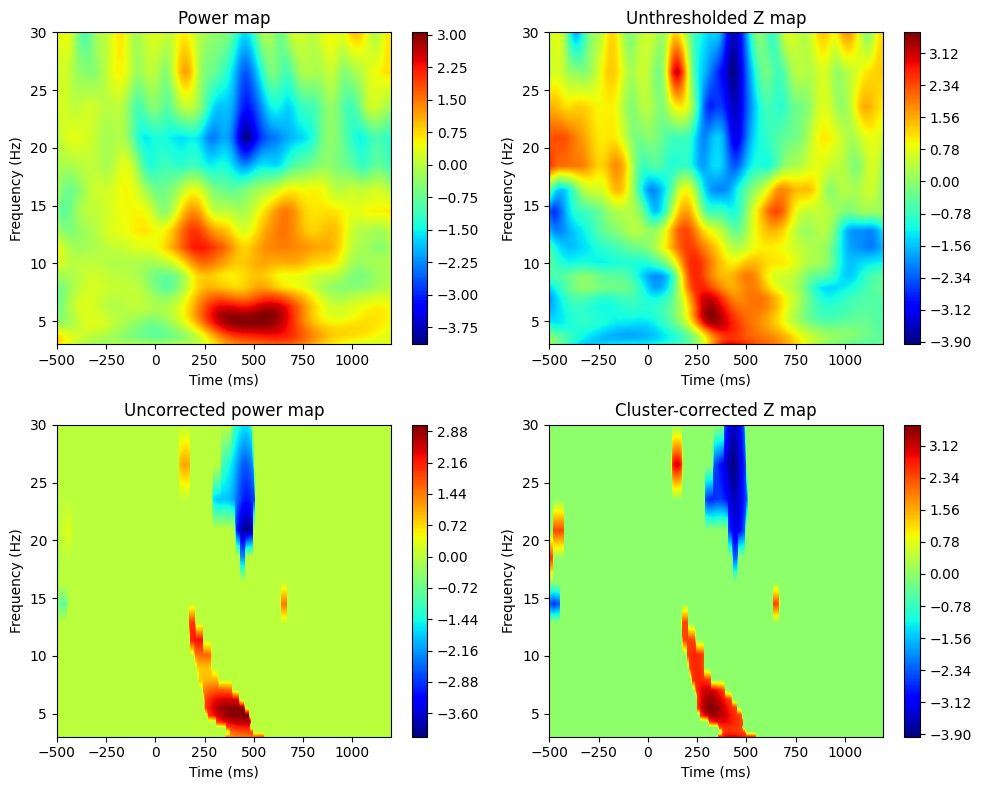

In [3]:
# Figure 34.1

voxel_pval = 0.01
cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

baseidx = [np.argmin(np.abs(tftimes - (-500))), np.argmin(np.abs(tftimes - (-100)))]

# Compute actual t-test of difference
realbaselines = np.mean(eegpower[:, baseidx[0]:baseidx[1], :], axis=1)
realbaselines = np.mean(realbaselines, axis=1)  # Average across the baseline time points
realmean = 10 * np.log10(np.mean(eegpower, axis=2) / realbaselines[:, None])  # Normalize power

# Initialize null hypothesis matrices
permuted_maxvals = np.zeros((n_permutes, 2, num_frex))
permuted_vals = np.zeros((n_permutes, num_frex, len(tftimes)))
max_clust_info = np.zeros(n_permutes)

# Correcting the cutpoint calculation
for permi in range(n_permutes):
    cutpoint = np.random.choice(range(2, nTimepoints - np.diff(baseidx)[0] - 2))
    permuted_data = np.roll(eegpower, cutpoint, axis=1)
    permuted_vals[permi, :, :] = 10 * np.log10(np.mean(permuted_data, axis=2) / realbaselines[:, None])

zmap = (realmean - np.mean(permuted_vals, axis=0)) / np.std(permuted_vals, axis=0)
threshmean = realmean.copy()
threshmean[np.abs(zmap) < norm.ppf(1 - voxel_pval)] = 0

# Plotting the figures
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Power map
ax = axs[0, 0]
cf = ax.contourf(tftimes, frex, realmean, 40, cmap='jet', levels=256)
ax.set_title('Power map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Unthresholded Z map
ax = axs[0, 1]
cf = ax.contourf(tftimes, frex, zmap, 40, cmap='jet', levels=256)
ax.set_title('Unthresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Uncorrected power map
ax = axs[1, 0]
cf = ax.contourf(tftimes, frex, threshmean, 40, cmap='jet', levels=256)
ax.set_title('Uncorrected power map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Apply cluster-level corrected threshold
zmapthresh = zmap.copy()
# Uncorrected pixel-level threshold
zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0

# Find islands and remove those smaller than cluster size threshold
labeled_array, num_features = label(zmapthresh)
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
clust_threshold = np.percentile(max_clust_info, 100 - cluster_pval * 100)

# Identify clusters to remove
whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing

# Remove clusters
for clust in whichclusters2remove:
    zmapthresh[labeled_array == clust] = 0

# Plotting the cluster-corrected Z map
ax = axs[1, 1]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='jet', levels=256)
ax.set_title('Cluster-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

plt.tight_layout()
plt.show()

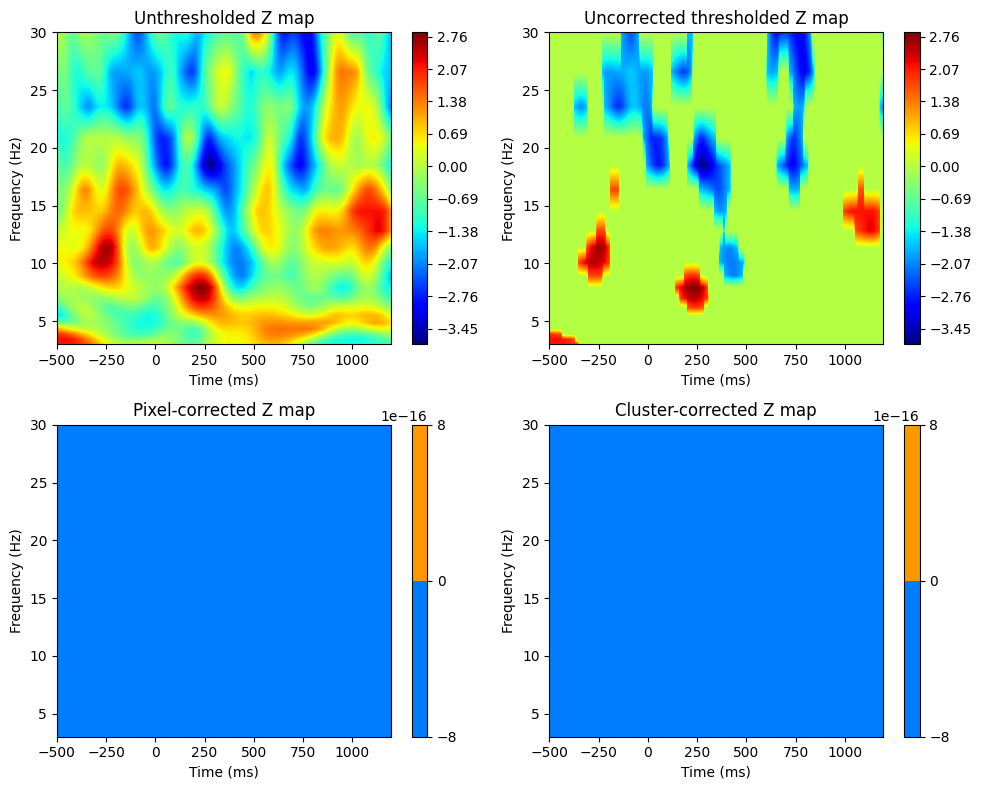

In [4]:
# Figure 34.3

voxel_pval = 0.05
mcc_voxel_pval = 0.05  # mcc = multiple comparisons correction
mcc_cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

real_condition_mapping = np.concatenate((-np.ones(int(np.floor(EEG['trials'][0, 0] / 2))), np.ones(int(np.ceil(EEG['trials'][0, 0] / 2)))))

# Compute actual t-test of difference (using unequal N and std)
tnum = np.mean(eegpower[:, :, real_condition_mapping == -1], axis=2) - np.mean(eegpower[:, :, real_condition_mapping == 1], axis=2)
tdenom = np.sqrt((np.std(eegpower[:, :, real_condition_mapping == -1], axis=2, ddof=1) ** 2) / np.sum(real_condition_mapping == -1) +
                 (np.std(eegpower[:, :, real_condition_mapping == 1], axis=2, ddof=1) ** 2) / np.sum(real_condition_mapping == 1))
real_t = tnum / tdenom

# Initialize null hypothesis matrices
permuted_tvals = np.zeros((n_permutes, num_frex, nTimepoints))
max_pixel_pvals = np.zeros((n_permutes, 2))
max_clust_info = np.zeros(n_permutes)

# Generate pixel-specific null hypothesis parameter distributions
for permi in range(n_permutes):
    fake_condition_mapping = np.sign(np.random.randn(EEG['trials'][0, 0]))
    
    # Compute t-map of null hypothesis
    tnum = np.mean(eegpower[:, :, fake_condition_mapping == -1], axis=2) - np.mean(eegpower[:, :, fake_condition_mapping == 1], axis=2)
    tdenom = np.sqrt((np.std(eegpower[:, :, fake_condition_mapping == -1], axis=2, ddof=1) ** 2) / np.sum(fake_condition_mapping == -1) +
                     (np.std(eegpower[:, :, fake_condition_mapping == 1], axis=2, ddof=1) ** 2) / np.sum(fake_condition_mapping == 1))
    tmap = tnum / tdenom
    
    # Save all permuted values
    permuted_tvals[permi, :, :] = tmap
    
    # Save maximum pixel values
    max_pixel_pvals[permi, :] = [np.min(tmap), np.max(tmap)]
    
    # For cluster correction, apply uncorrected threshold and get maximum cluster sizes
    tmap[np.abs(tmap) < t.ppf(1 - voxel_pval, EEG['trials'][0, 0] - 1)] = 0
    
    # Get number of elements in largest supra-threshold cluster
    labeled_array, num_features = label(tmap)
    max_clust_info[permi] = np.max([0] + [np.sum(labeled_array == i) for i in range(1, num_features + 1)])

# Now compute Z-map
zmap = (real_t - np.mean(permuted_tvals, axis=0)) / np.std(permuted_tvals, axis=0)

# Apply cluster-level corrected threshold
zmapthresh = zmap.copy()
# Uncorrected pixel-level threshold
zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0

# Find islands and remove those smaller than cluster size threshold
labeled_array, num_features = label(zmapthresh)
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
clust_threshold = np.percentile(max_clust_info, 100 - mcc_cluster_pval * 100)

# Identify clusters to remove
whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing

# Remove clusters
for clust in whichclusters2remove:
    zmapthresh[labeled_array == clust] = 0

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Unthresholded Z map
ax = axs[0, 0]
cf = ax.contourf(tftimes, frex, zmap, 40, cmap='jet', levels=256)
ax.set_title('Unthresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Apply uncorrected threshold
zmapthresh = zmap.copy()
zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0

# Uncorrected thresholded Z map
ax = axs[0, 1]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='jet', levels=256)
ax.set_title('Uncorrected thresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Apply pixel-level corrected threshold
lower_threshold = np.percentile(max_pixel_pvals[:, 0], mcc_voxel_pval * 100 / 2)
upper_threshold = np.percentile(max_pixel_pvals[:, 1], 100 - mcc_voxel_pval * 100 / 2)

zmapthresh = zmap.copy()
zmapthresh[(zmap > lower_threshold) & (zmap < upper_threshold)] = 0

# Pixel-corrected Z map
ax = axs[1, 0]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='jet', levels=256)
ax.set_title('Pixel-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Apply cluster-level corrected threshold
zmapthresh = zmap.copy()
zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0

# Find islands and remove those smaller than cluster size threshold
labeled_array, num_features = label(zmapthresh)
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
clust_threshold = np.percentile(max_clust_info, 100 - mcc_cluster_pval * 100)

# Identify clusters to remove
whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing

# Remove clusters
for clust in whichclusters2remove:
    zmapthresh[labeled_array == clust] = 0

# Cluster-corrected Z map
ax = axs[1, 1]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='jet', levels=256)
ax.set_title('Cluster-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

plt.tight_layout()
plt.show()

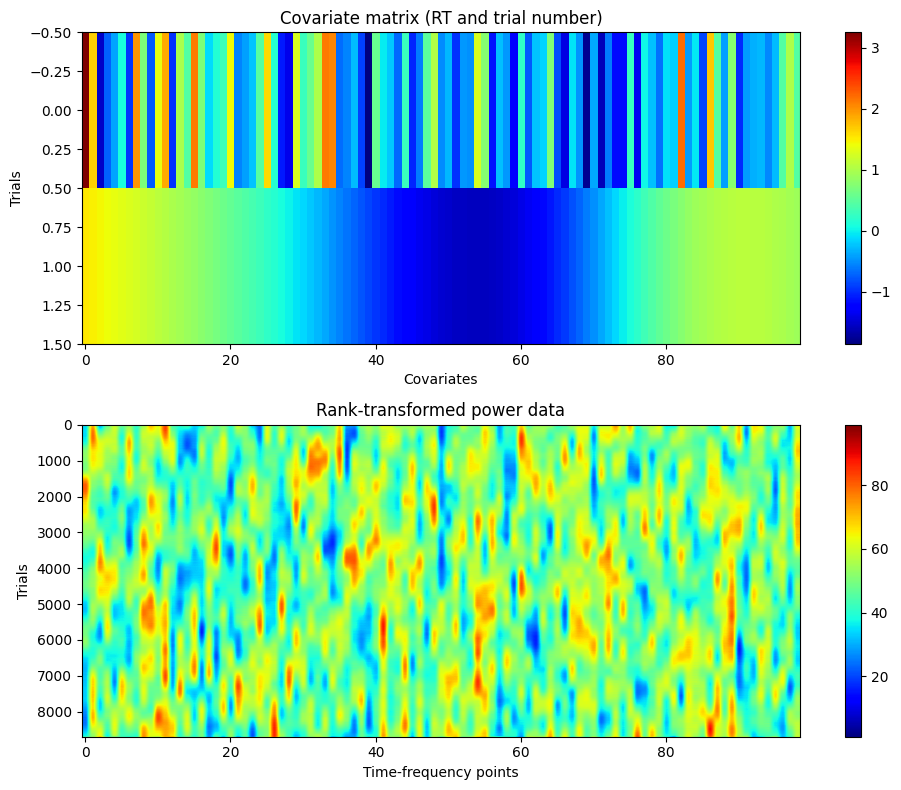

In [5]:
# Figure 34.4

# Define the channel and time-frequency window of interest
chan2use = 'O1'
time2use = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in [0, 250]])
freq2use = np.argmin(np.abs(frex - 10))

# FFT and convolution for the selected channel and frequency
eegfft = fft(EEG['data'][EEG['chanlocs'][0]['labels']==chan2use, :, :].flatten('F'), n_conv_pow2)
eegconv = ifft(wavelets[freq2use, :] * eegfft)
eegconv = eegconv[:n_convolution]
eegconv = eegconv[half_of_wavelet_size: -half_of_wavelet_size]

# Reshape to time X trials and extract power
temp = np.abs(np.reshape(eegconv, (EEG['pnts'][0][0], EEG['trials'][0][0]))) ** 2
o1power = stats.zscore(np.mean(temp[time2use[0]:time2use[1], :], axis=0))

# Define covariates (RT and trial number)
rts = np.zeros(EEG['trials'][0][0])
for ei in range(EEG['trials'][0][0]):
    time0event = np.where(np.array(EEG['epoch'][0][ei]['eventlatency'][0]) == 0)[0][0]
    rts[ei] = EEG['epoch'][0][ei]['eventlatency'][0][time0event + 1]

# Rank-transform RTs
rtsrank = rankdata(rts)

# Rank-transform power data (must be transformed)
eegpowerreshaped = np.reshape(eegpower, (num_frex * nTimepoints, EEG['trials'][0][0]), 'F').T
eegpowerrank = rankdata(eegpowerreshaped, axis=0).T

# Covariate matrix
X = np.vstack((stats.zscore(rts), o1power))

# Plotting the covariate matrix and rank-transformed power data
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Covariate matrix
ax = axs[0]
cax = ax.imshow(X, aspect='auto', cmap='jet')
ax.set_title('Covariate matrix (RT and trial number)')
ax.set_xlabel('Covariates')
ax.set_ylabel('Trials')
fig.colorbar(cax, ax=ax)

# Rank-transformed power data
ax = axs[1]
cax = ax.imshow(eegpowerrank, aspect='auto', cmap='jet')
ax.set_title('Rank-transformed power data')
ax.set_xlabel('Time-frequency points')
ax.set_ylabel('Trials')
fig.colorbar(cax, ax=ax)

plt.tight_layout()
plt.show()

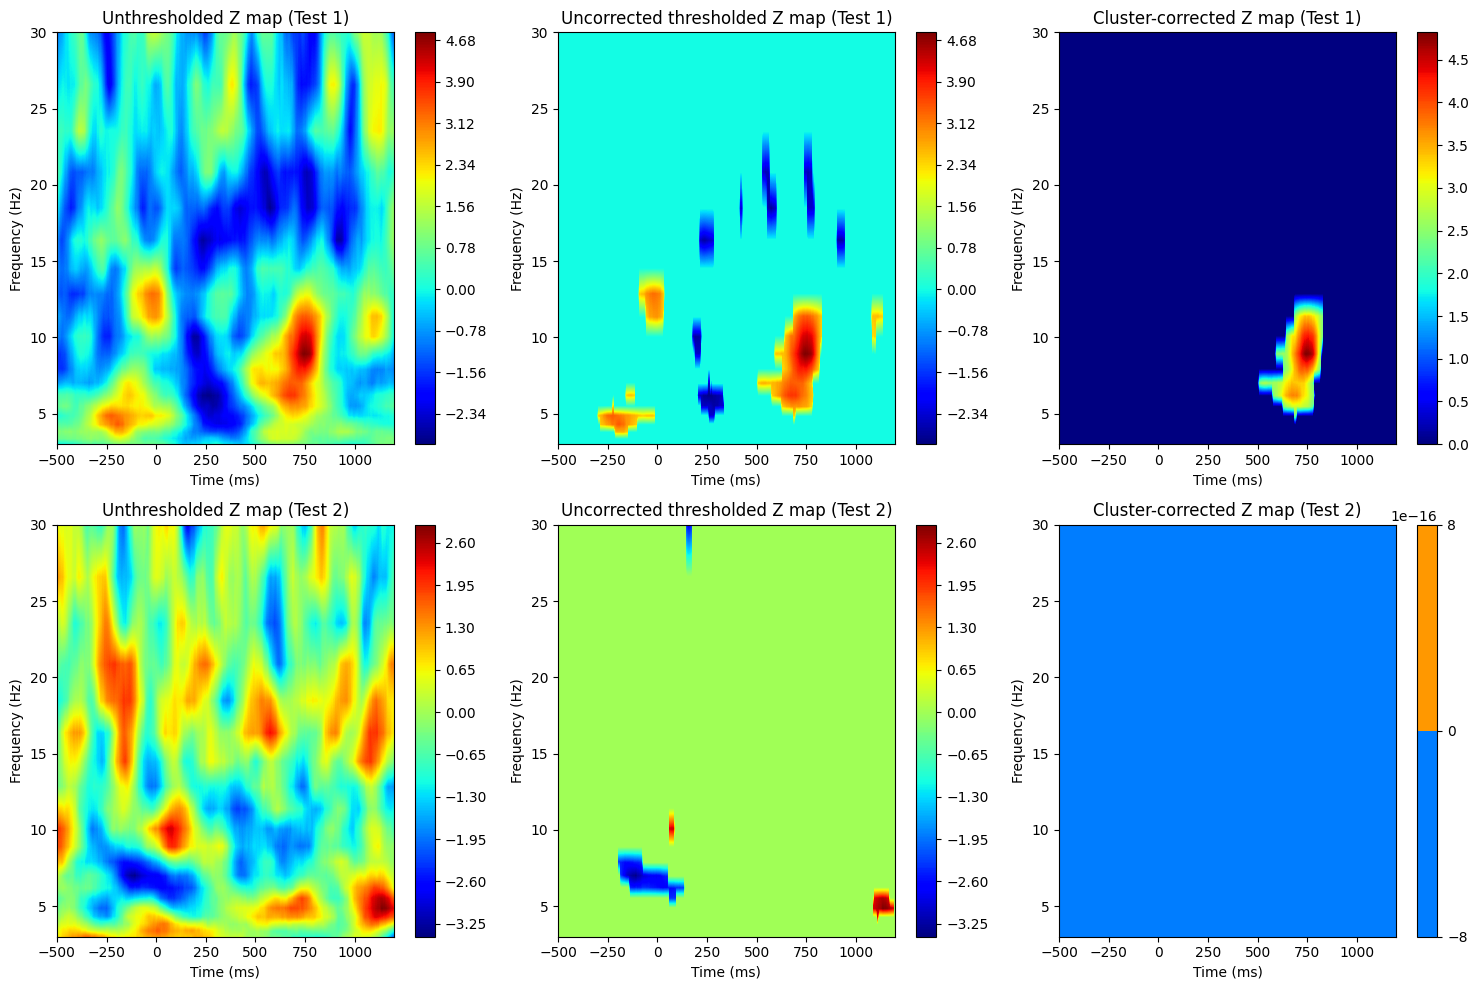

In [6]:
# Figure 34.6

voxel_pval = 0.01
mcc_cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

# Perform multiple regression analysis
# Ensure that X has two rows (covariates) and the number of trials as columns
X = np.vstack((stats.zscore(rts), o1power)).T  # Transpose to get trials as columns

# Ensure that eegpowerrank is a 2D array with trials as rows
eegpowerrank = rankdata(eegpowerreshaped, axis=0)

# Perform the regression using np.linalg.lstsq
realbeta = np.linalg.lstsq(X, eegpowerrank, rcond=None)[0]
realbeta = np.reshape(realbeta, (2, num_frex, nTimepoints), order='F')

# Initialize null hypothesis matrices
permuted_bvals = np.zeros((n_permutes, 2, num_frex, nTimepoints))
max_clust_info = np.zeros((n_permutes, 2))

# Generate pixel-specific null hypothesis parameter distributions
for permi in range(n_permutes):
    # Randomly shuffle trial order
    fakeX = X[np.random.permutation(EEG['trials'][0][0]), :]
    
    # Compute beta-map of null hypothesis
    fakebeta = np.linalg.lstsq(fakeX, eegpowerrank, rcond=None)[0]
    fakebeta = np.reshape(fakebeta, (2, num_frex, nTimepoints), order='F')
    
    # Save all permuted values
    permuted_bvals[permi, :, :, :] = fakebeta

# Cluster correction will be done on the permuted data
for permi in range(n_permutes):
    for testi in range(2):
        # Apply uncorrected threshold and get maximum cluster sizes
        fakecorrsz = (permuted_bvals[permi, testi, :, :] - np.mean(permuted_bvals[:, testi, :, :], axis=0)) / np.std(permuted_bvals[:, testi, :, :], axis=0)
        fakecorrsz[np.abs(fakecorrsz) < norm.ppf(1 - voxel_pval)] = 0
        
        # Get number of elements in largest supra-threshold cluster
        labeled_array, num_features = label(fakecorrsz)
        max_clust_info[permi, testi] = np.max([0] + [np.sum(labeled_array == i) for i in range(1, num_features + 1)])

# Now compute Z-map
zmap = (realbeta - np.mean(permuted_bvals, axis=0)) / np.std(permuted_bvals, axis=0)

# Plotting the figures for Figure 34.6
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for testi in range(2):
    # Unthresholded Z map
    ax = axs[testi, 0]
    cf = ax.contourf(tftimes, frex, zmap[testi, :, :], 40, cmap='jet', levels=256)
    ax.set_title(f'Unthresholded Z map (Test {testi + 1})')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(cf, ax=ax)
    
    # Apply uncorrected threshold
    zmapthresh = zmap[testi, :, :].copy()
    zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0
    
    # Uncorrected thresholded Z map
    ax = axs[testi, 1]
    cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='jet', levels=256)
    ax.set_title(f'Uncorrected thresholded Z map (Test {testi + 1})')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(cf, ax=ax)
    
    # Apply cluster-level corrected threshold
    clust_threshold = np.percentile(max_clust_info[:, testi], 100 - mcc_cluster_pval * 100)
    
    # Find islands and remove those smaller than cluster size threshold
    labeled_array, num_features = label(zmapthresh)
    cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
    
    # Identify clusters to remove
    whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing
    
    # Remove clusters
    for clust in whichclusters2remove:
        zmapthresh[labeled_array == clust] = 0
    
    # Cluster-corrected Z map
    ax = axs[testi, 2]
    cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='jet', levels=256)
    ax.set_title(f'Cluster-corrected Z map (Test {testi + 1})')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(cf, ax=ax)

plt.tight_layout()
plt.show()

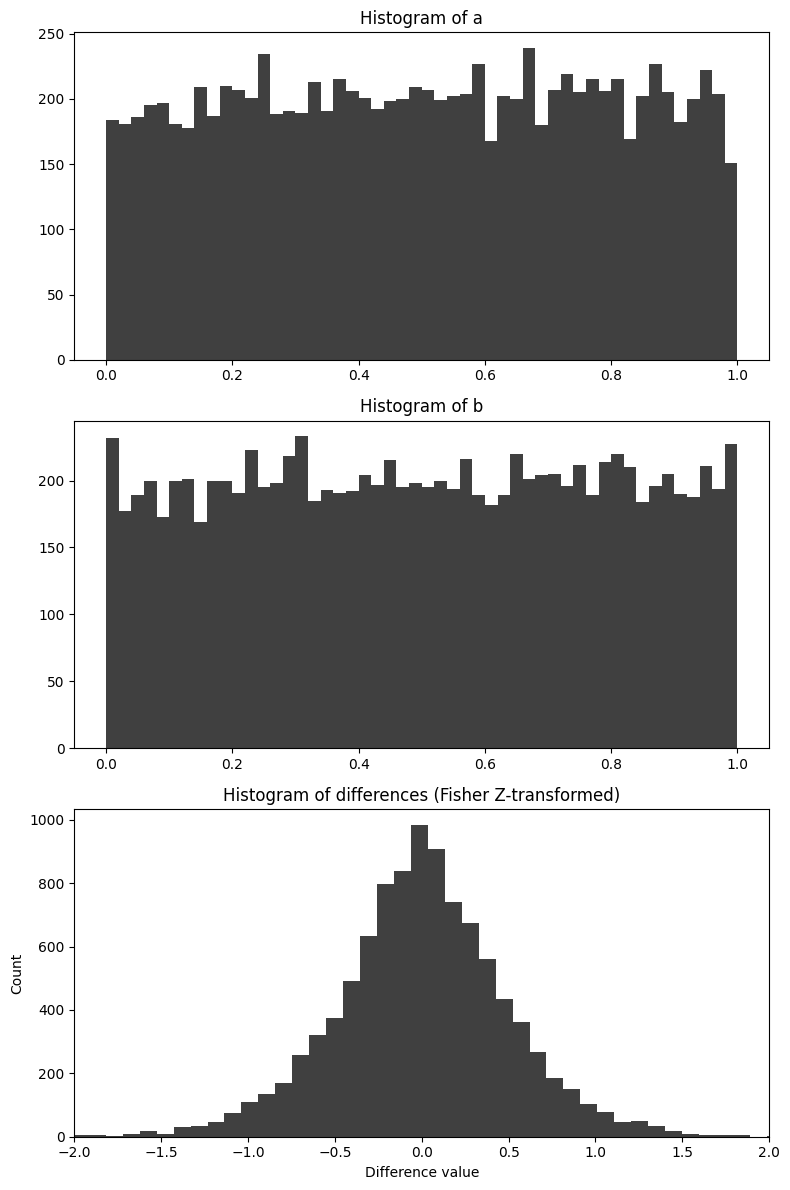

In [7]:
# Figure 34.7

# Generate random data
a = np.random.rand(10000, 1)
b = np.random.rand(10000, 1)

# Create figure and axes
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Histogram of 'a'
ax = axs[0]
ax.hist(a, bins=50, color='k', alpha=0.75)
ax.set_xlim([-.05, 1.05])
ax.set_title('Histogram of a')

# Histogram of 'b'
ax = axs[1]
ax.hist(b, bins=50, color='k', alpha=0.75)
ax.set_xlim([-.05, 1.05])
ax.set_title('Histogram of b')

# Histogram of the differences (using Fisher's Z transformation)
ax = axs[2]
ax.hist(np.arctanh(a - b), bins=50, color='k', alpha=0.75)
ax.set_xlim([-2, 2])
ax.set_title('Histogram of differences (Fisher Z-transformed)')
ax.set_xlabel('Difference value')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

/var/folders/6s/__zkn53s2bg90cyp78pt9zgm0000gn/T/ipykernel_9442/3834890271.py:26: RuntimeWarning: divide by zero encountered in divide
  zmap = (realitpc - np.mean(permuted_vals, axis=0)) / np.std(permuted_vals, axis=0)


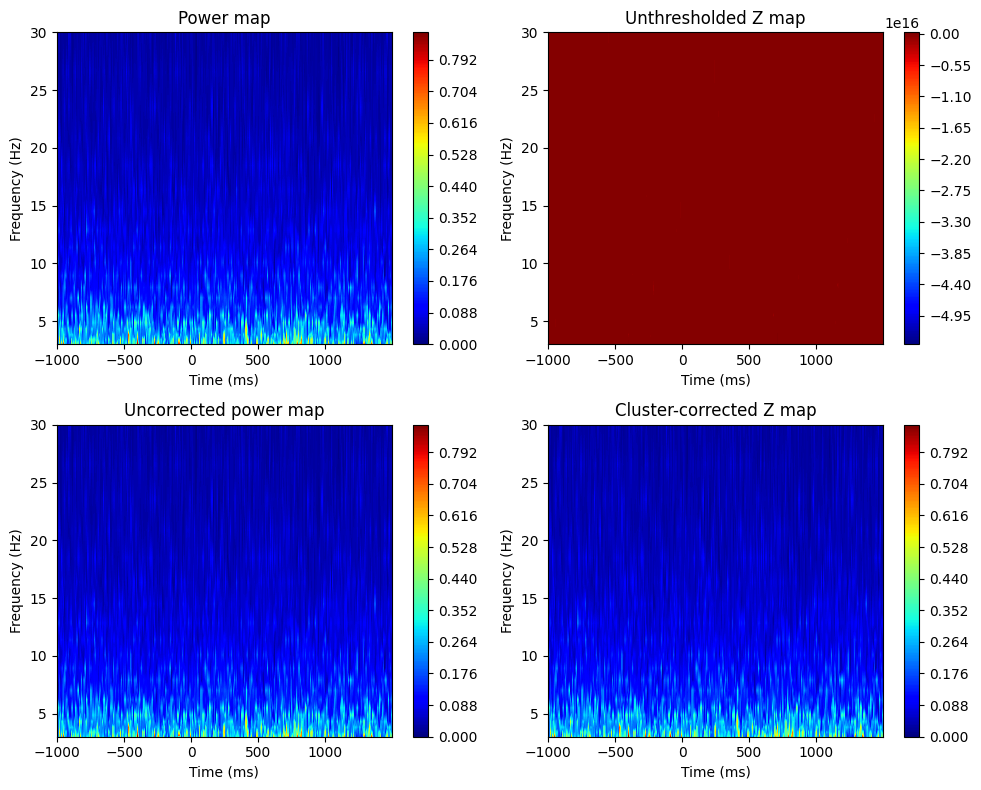

In [12]:
# Figure 34.9

voxel_pval = 0.01
cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

# Compute actual ITPC
realitpc = np.abs(np.mean(eegphase, axis=2))

# Initialize null hypothesis matrices
permuted_vals = np.zeros((n_permutes, num_frex, EEG['pnts'][0][0]))
max_clust_info = np.zeros(n_permutes)

for permi in range(n_permutes):
    # Permute phase angles across trials (this is a 2D operation)
    for fi in range(num_frex):
        # Randomly select a cutpoint for the permutation
        cutpoint = np.random.choice(range(2, nTimepoints - 2))
        # Roll the phase data across the time dimension
        permuted_phase_data = np.roll(eegphase[fi, :, :], cutpoint, axis=1)
        # Compute ITPC for permuted data
        permuted_vals[permi, fi, :] = np.abs(np.mean(np.exp(1j * permuted_phase_data), axis=1))

zmap = (realitpc - np.mean(permuted_vals, axis=0)) / np.std(permuted_vals, axis=0)
threshmean = realitpc.copy()
threshmean[np.abs(zmap) < norm.ppf(1 - voxel_pval)] = 0

# Plotting the figures for Figure 34.9
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Power map
ax = axs[0, 0]
cf = ax.contourf(EEG['times'][0], frex, realitpc, 40, cmap='jet', levels=256)
ax.set_title('Power map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Unthresholded Z map
ax = axs[0, 1]
cf = ax.contourf(EEG['times'][0], frex, zmap, 40, cmap='jet', levels=256)
ax.set_title('Unthresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Uncorrected power map
ax = axs[1, 0]
cf = ax.contourf(EEG['times'][0], frex, threshmean, 40, cmap='jet', levels=256)
ax.set_title('Uncorrected power map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

# Cluster-corrected Z map
# Apply cluster-level corrected threshold
zmapthresh = realitpc.copy()
zmapthresh[np.abs(zmap) < norm.ppf(1 - voxel_pval)] = 0

# Find islands and remove those smaller than cluster size threshold
labeled_array, num_features = label(zmapthresh)
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
clust_threshold = np.percentile(max_clust_info, 100 - cluster_pval * 100)

# Identify clusters to remove
whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing

# Remove clusters
for clust in whichclusters2remove:
    zmapthresh[labeled_array == clust] = 0

ax = axs[1, 1]
cf = ax.contourf(EEG['times'][0], frex, zmapthresh, 40, cmap='jet', levels=256)
ax.set_title('Cluster-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(cf, ax=ax)

plt.tight_layout()
plt.show()

In [19]:
eegpower[4, 400, real_condition_mapping == -1][np.newaxis, np.newaxis, :].shape

(1, 1, 49)

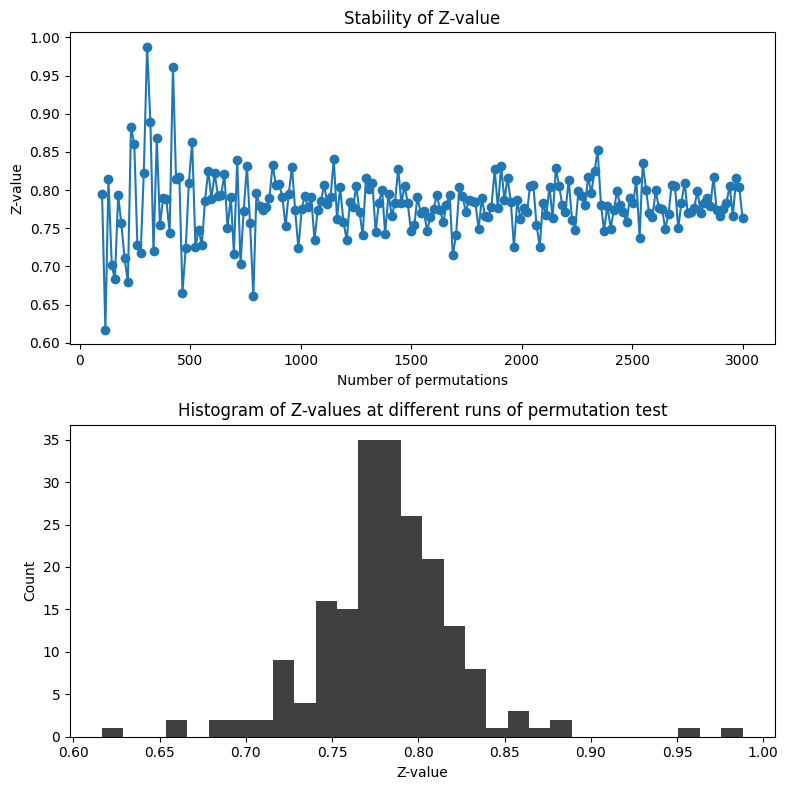

In [21]:
# Figure 33.5

# Compute actual t-test of difference (using unequal N and std)
tnum = np.mean(eegpower[4, 400, real_condition_mapping == -1]) - np.mean(eegpower[4, 400, real_condition_mapping == 1])
tdenom = np.sqrt((np.std(eegpower[4, 400, real_condition_mapping == -1], ddof=1) ** 2) / np.sum(real_condition_mapping == -1) +
                 (np.std(eegpower[4, 400, real_condition_mapping == 1], ddof=1) ** 2) / np.sum(real_condition_mapping == 1))
real_t = tnum / tdenom

# Set up the range of permutations to test
n_permutes_range = np.round(np.linspace(100, 3000, 200)).astype(int)
zvals = np.zeros(len(n_permutes_range))

# Perform the permutation test for different numbers of permutations
for idx, n_permutes in enumerate(n_permutes_range):
    permuted_tvals = np.zeros(n_permutes)
    
    # Generate null hypothesis parameter distributions
    for permi in range(n_permutes):
        fake_condition_mapping = np.sign(np.random.randn(EEG['trials'][0][0]))
        tnum = np.mean(eegpower[4, 400, fake_condition_mapping == -1]) - np.mean(eegpower[4, 400, fake_condition_mapping == 1])
        tdenom = np.sqrt((np.std(eegpower[4, 400, fake_condition_mapping == -1], ddof=1) ** 2) / np.sum(fake_condition_mapping == -1) +
                         (np.std(eegpower[4, 400, fake_condition_mapping == 1], ddof=1) ** 2) / np.sum(fake_condition_mapping == 1))
        permuted_tvals[permi] = tnum / tdenom
    
    zvals[idx] = (real_t - np.mean(permuted_tvals)) / np.std(permuted_tvals)

# Plot the stability of Z-value as a function of the number of permutations
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot Z-values
ax = axs[0]
ax.plot(n_permutes_range, zvals, marker='o', linestyle='-')
ax.set_xlabel('Number of permutations')
ax.set_ylabel('Z-value')
ax.set_title('Stability of Z-value')

# Histogram of Z-values
ax = axs[1]
ax.hist(zvals, bins=30, color='k', alpha=0.75)
ax.set_xlabel('Z-value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Z-values at different runs of permutation test')

plt.tight_layout()
plt.show()

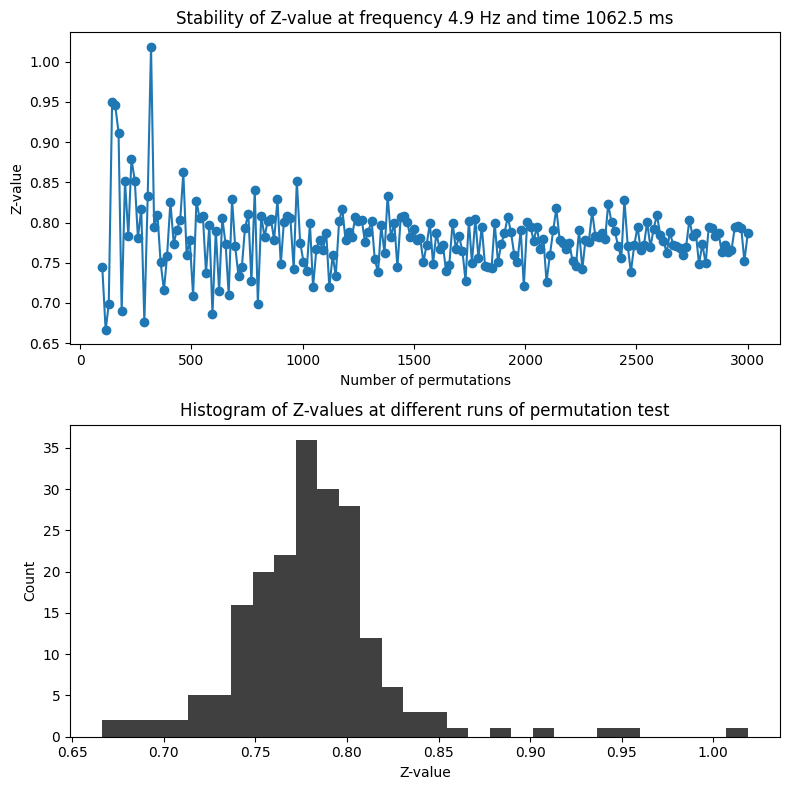

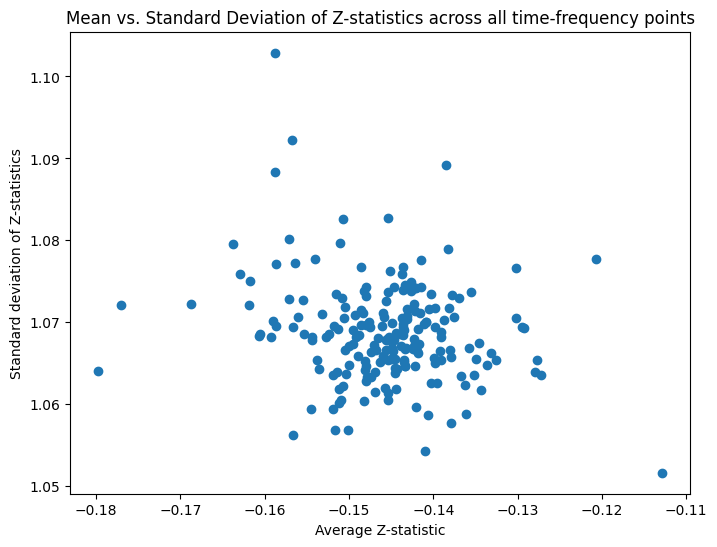

In [23]:
# Figure 33.6

# Compute actual t-test of difference (using unequal N and std)
tnum = np.mean(eegpower[:, :, real_condition_mapping == -1], axis=2) - np.mean(eegpower[:, :, real_condition_mapping == 1], axis=2)
tdenom = np.sqrt((np.std(eegpower[:, :, real_condition_mapping == -1], axis=2, ddof=1) ** 2) / np.sum(real_condition_mapping == -1) +
                 (np.std(eegpower[:, :, real_condition_mapping == 1], axis=2, ddof=1) ** 2) / np.sum(real_condition_mapping == 1))
real_t = tnum / tdenom

# Set up the range of permutations to test
n_permutes_range = np.round(np.linspace(100, 3000, 200)).astype(int)
zvals = np.zeros((len(n_permutes_range), num_frex, nTimepoints))

# Perform the permutation test for different numbers of permutations
for idx, n_permutes in enumerate(n_permutes_range):
    permuted_tvals = np.zeros((n_permutes, num_frex, nTimepoints))
    
    # Generate null hypothesis parameter distributions
    for permi in range(n_permutes):
        fake_condition_mapping = np.sign(np.random.randn(EEG['trials'][0][0]))
        tnum = np.mean(eegpower[:, :, fake_condition_mapping == -1], axis=2) - np.mean(eegpower[:, :, fake_condition_mapping == 1], axis=2)
        tdenom = np.sqrt((np.std(eegpower[:, :, fake_condition_mapping == -1], axis=2, ddof=1) ** 2) / np.sum(fake_condition_mapping == -1) +
                         (np.std(eegpower[:, :, fake_condition_mapping == 1], axis=2, ddof=1) ** 2) / np.sum(fake_condition_mapping == 1))
        permuted_tvals[permi, :, :] = tnum / tdenom
    
    zvals[idx, :, :] = (real_t - np.mean(permuted_tvals, axis=0)) / np.std(permuted_tvals, axis=0)

# Select a single time-frequency point for plotting
selected_freq = 4
selected_time = 400

# Plot the stability of Z-value as a function of the number of permutations for the selected time-frequency point
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot Z-values for the selected time-frequency point
ax = axs[0]
ax.plot(n_permutes_range, zvals[:, selected_freq, selected_time], marker='o', linestyle='-')
ax.set_xlabel('Number of permutations')
ax.set_ylabel('Z-value')
ax.set_title(f'Stability of Z-value at frequency {frex[selected_freq]:.1f} Hz and time {tftimes[selected_time]} ms')

# Histogram of Z-values for the selected time-frequency point
ax = axs[1]
ax.hist(zvals[:, selected_freq, selected_time], bins=30, color='k', alpha=0.75)
ax.set_xlabel('Z-value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Z-values at different runs of permutation test')

plt.tight_layout()
plt.show()

# Plot the average and standard deviation of Z-statistics across all time-frequency points
zvals_all = zvals.reshape(len(n_permutes_range), num_frex * nTimepoints)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.mean(zvals_all, axis=1), np.std(zvals_all, axis=1), 'o')
# ax.set_xlim([-3.5, 3.5])
# ax.set_ylim([0, 0.12])
ax.set_xlabel('Average Z-statistic')
ax.set_ylabel('Standard deviation of Z-statistics')
ax.set_title('Mean vs. Standard Deviation of Z-statistics across all time-frequency points')
plt.show()